In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd

import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cuda


# Data cleaning
- Remove columns that won't be passed through the model
- Find and replace/remove missing data

In [3]:
train_dataset = pd.read_csv("/kaggle/input/titanic/train.csv")
train_dataset.sample(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
716,717,1,1,"Endres, Miss. Caroline Louise",female,38.0,0,0,PC 17757,227.5250,C45,C
501,502,0,3,"Canavan, Miss. Mary",female,21.0,0,0,364846,7.7500,NaN,Q
861,862,0,2,"Giles, Mr. Frederick Edward",male,21.0,1,0,28134,11.5000,NaN,S
572,573,1,1,"Flynn, Mr. John Irwin (""Irving"")",male,36.0,0,0,PC 17474,26.3875,E25,S
529,530,0,2,"Hocking, Mr. Richard George",male,23.0,2,1,29104,11.5000,NaN,S


In [4]:
train_dataset.drop(columns=["Name", "Cabin", "Ticket", "PassengerId"], inplace=True)

In [5]:
train_dataset.sample(n=4)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
820,1,1,female,52.0,1,1,93.5000,S
625,0,1,male,61.0,0,0,32.3208,S
838,1,3,male,32.0,0,0,56.4958,S
215,1,1,female,31.0,1,0,113.2750,C


In [6]:
def clean_data(data, column, total_null):
    if total_null <= len(data) * (5/100): # less than 5%
        data.dropna(subset=[column], inplace=True)
        
def check_data(data, clean: bool):
    for column in data.columns:
        if data[column].isnull().any():
            total_null_entries = data[column].isnull().sum()
            null_percent = total_null_entries / len(data) * 100
            print(f"null value found in the column {column}; totaling {total_null_entries} null entries; {null_percent}%")
            
            if clean:
                clean_data(data=data, column=column, total_null=total_null_entries)
        if column not in ["Age", "Fare", "PassengerId"]:
            print(f"{column} unique values --> {data[column].unique()}")

In [7]:
check_data(data=train_dataset, clean=True)
check_data(data=train_dataset, clean=False)

Survived unique values --> [0 1]
Pclass unique values --> [3 1 2]
Sex unique values --> ['male' 'female']
null value found in the column Age; totaling 177 null entries; 19.865319865319865%
SibSp unique values --> [1 0 3 4 2 5 8]
Parch unique values --> [0 1 2 5 3 4 6]
null value found in the column Embarked; totaling 2 null entries; 0.22446689113355783%
Embarked unique values --> ['S' 'C' 'Q']
Survived unique values --> [0 1]
Pclass unique values --> [3 1 2]
Sex unique values --> ['male' 'female']
null value found in the column Age; totaling 177 null entries; 19.910011248593925%
SibSp unique values --> [1 0 3 4 2 5 8]
Parch unique values --> [0 1 2 5 3 4 6]
Embarked unique values --> ['S' 'C' 'Q']


In [8]:
median_age = train_dataset["Age"].median()
train_dataset.fillna({"Age": median_age}, inplace=True)

In [9]:
train_dataset.sample(n=5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
694,0,1,male,60.0,0,0,26.550,S
708,1,1,female,22.0,0,0,151.550,S
92,0,1,male,46.0,1,0,61.175,S
712,1,1,male,48.0,1,0,52.000,S
256,1,1,female,28.0,0,0,79.200,C


# Data visualization, survival comparison
- Visualize the relation within the data

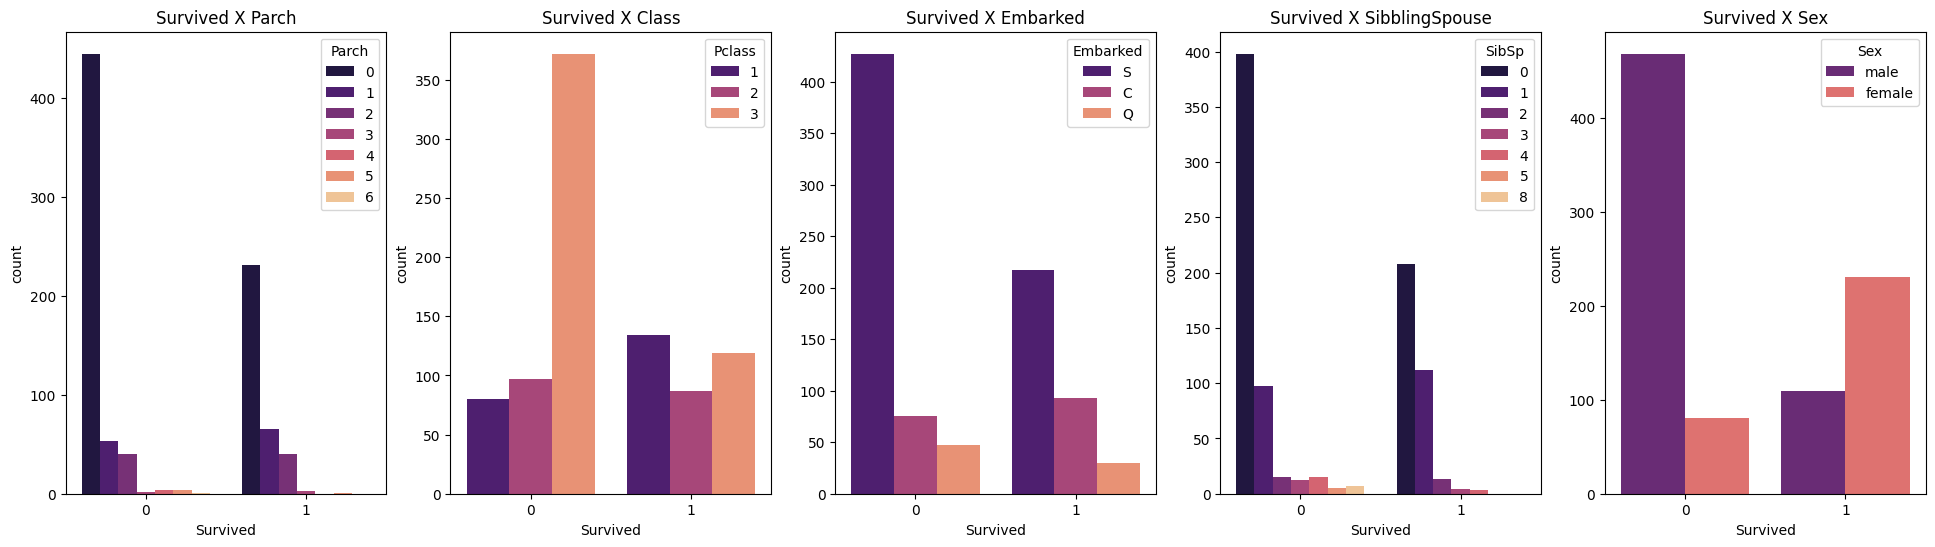

In [10]:
def plot_data(data):
    fig, axis = plt.subplots(1, 5, figsize=(24, 6))
    sns.countplot(data=data, x="Survived", hue="Parch", palette="magma", ax=axis[0])
    sns.countplot(data=data, x="Survived", hue="Pclass", palette="magma", ax=axis[1])
    sns.countplot(data=data, x="Survived", hue="Embarked", palette="magma", ax=axis[2])
    sns.countplot(data=data, x="Survived", hue="SibSp", palette="magma", ax=axis[3])
    sns.countplot(data=data, x="Survived", hue="Sex", palette="magma", ax=axis[4])
    
    axis[0].set_title("Survived X Parch")
    axis[1].set_title("Survived X Class")
    axis[2].set_title("Survived X Embarked")
    axis[3].set_title("Survived X SibblingSpouse")
    axis[4].set_title("Survived X Sex")
    
    plt.show()
plot_data(data=train_dataset)

# Mapping classes to numbers

In [11]:
sex_mapping = {k: v for v, k in enumerate(train_dataset["Sex"].unique())}
embarked_mapping = {k: v for v, k in enumerate(train_dataset["Embarked"].unique())}

train_dataset["Sex"] = train_dataset["Sex"].map(sex_mapping)
train_dataset["Embarked"] = train_dataset["Embarked"].map(embarked_mapping)
train_dataset.sample(n=5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
248,1,1,0,37.00,1,1,52.5542,0
755,1,2,0,0.67,1,1,14.5000,0
245,0,1,0,44.00,2,0,90.0000,2
533,1,3,1,28.00,0,2,22.3583,1
614,0,3,0,35.00,0,0,8.0500,0


# Get batch function

In [12]:
def get_batch(data, batch_size):
    batch = data.sample(n=batch_size)
    batch_labels = batch["Survived"].to_numpy()
    batch_inputs = batch.drop(columns=["Survived"]).to_numpy()
    
    batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)
    
    return (batch_inputs, batch_labels)

get_batch(data=train_dataset, batch_size=4)

(tensor([[ 3.0000,  0.0000, 28.0000,  0.0000,  0.0000, 22.5250,  0.0000],
         [ 3.0000,  1.0000, 19.0000,  0.0000,  0.0000,  7.8792,  2.0000],
         [ 3.0000,  0.0000, 18.0000,  1.0000,  1.0000,  7.8542,  0.0000],
         [ 3.0000,  0.0000, 20.0000,  0.0000,  0.0000,  7.8542,  0.0000]],
        device='cuda:0'),
 tensor([0, 1, 0, 0], device='cuda:0'))

In [13]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_classes, hidden_units_array, n_layers, dropout):
        super(MLP, self).__init__()
        layers = []
        prev_hidden_units = n_inputs
        
        for _ in range(n_layers):
            for hidden_units in hidden_units_array:
                layers.append(nn.Linear(in_features=prev_hidden_units, out_features=hidden_units))
                #layers.append(nn.BatchNorm1d(hidden_units))
                layers.append(nn.LayerNorm(hidden_units))
                layers.append(nn.LeakyReLU())
                #layers.append(nn.Dropout(dropout))
                print(f"from {prev_hidden_units} to {hidden_units}")
                prev_hidden_units = hidden_units
            #layers.append(nn.LayerNorm(hidden_units_array[-1]))
        #layers.append(nn.LayerNorm(hidden_units_array[-1]))
        layers.append(nn.Linear(in_features=hidden_units_array[-1], out_features=n_classes))
        
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #return self.network(x) # (B, n_classes)
        x = self.network(x)
        return x

In [14]:
n_inputs = len(train_dataset.drop(columns=["Survived"]).columns)
n_classes = 1 # Either dead of alive; Binary Cross Entropy should suffice
#hidden_units_array = [8*8, 8*8*8, 8*8*8*8, 8*8*8*8]
hidden_units_array = [8*8*8, 8*8*8, 8*8*8, 8*8*8]
n_layers = 3
dropout = 0.15
model = MLP(n_inputs=n_inputs, n_classes=n_classes, hidden_units_array=hidden_units_array, n_layers=n_layers, dropout=dropout)

from 7 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512
from 512 to 512


In [15]:
test_loss_fn = nn.BCEWithLogitsLoss()
model.eval()
with torch.inference_mode():
    batch_inputs, batch_labels = get_batch(data=train_dataset, batch_size=32)
    logits = model(batch_inputs) # (B, n_classes); labels are (B,)
    loss = test_loss_fn(logits.view(-1), batch_labels.to(torch.float32)) # For BCEWithLogitsLoss, labels must be in float32 format; for CrossEntropyLoss use torch.long instead
    print(loss)

tensor(0.7487, device='cuda:0')


In [16]:
def train_model(model, data, batch_size, loss_fn, optimizer, epochs):
    model.train()

    #writer = SummaryWriter()
    #writer.add_text('Model Architecture', str(model))

    for epoch in tqdm(range(epochs)):
        batch_inputs, batch_labels = get_batch(data=train_dataset, batch_size=batch_size)
        logits = model(batch_inputs) # (B, n_classes)
        loss = loss_fn(logits.view(-1), batch_labels.to(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #scheduler.step()

        #writer.add_scalar("Training Loss", loss.item(), epoch)

        
        if (epoch+1) % 500 == 0:
            print(f"loss for epoch {epoch+1} --> {loss}")
            #print(batch_inputs)
            #print(logits)
    #writer.close()

In [17]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)
loss_fn = nn.BCEWithLogitsLoss()

epochs = 30000
train_model(model=model, data=train_dataset, batch_size=256, loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)

  2%|▏         | 511/30000 [00:04<04:42, 104.54it/s]

loss for epoch 500 --> 0.4318639039993286


  3%|▎         | 1012/30000 [00:09<04:30, 107.02it/s]

loss for epoch 1000 --> 0.2856111228466034


  5%|▌         | 1513/30000 [00:14<04:24, 107.66it/s]

loss for epoch 1500 --> 0.2901860177516937


  7%|▋         | 2021/30000 [00:19<04:17, 108.55it/s]

loss for epoch 2000 --> 0.2914644479751587


  8%|▊         | 2511/30000 [00:23<04:11, 109.13it/s]

loss for epoch 2500 --> 0.23706293106079102


 10%|█         | 3019/30000 [00:28<04:07, 108.89it/s]

loss for epoch 3000 --> 0.24958378076553345


 12%|█▏        | 3521/30000 [00:33<04:09, 106.18it/s]

loss for epoch 3500 --> 0.22984667122364044


 13%|█▎        | 4017/30000 [00:37<04:00, 108.08it/s]

loss for epoch 4000 --> 0.18716485798358917


 15%|█▌        | 4513/30000 [00:42<03:53, 109.08it/s]

loss for epoch 4500 --> 0.2152276635169983


 17%|█▋        | 5018/30000 [00:47<03:54, 106.46it/s]

loss for epoch 5000 --> 0.16482950747013092


 18%|█▊        | 5511/30000 [00:51<03:45, 108.59it/s]

loss for epoch 5500 --> 0.18029451370239258


 20%|██        | 6020/30000 [00:56<03:42, 107.70it/s]

loss for epoch 6000 --> 0.1520034670829773


 22%|██▏       | 6521/30000 [01:01<03:38, 107.59it/s]

loss for epoch 6500 --> 0.16727888584136963


 23%|██▎       | 7020/30000 [01:05<03:31, 108.80it/s]

loss for epoch 7000 --> 0.17981065809726715


 25%|██▌       | 7518/30000 [01:10<03:26, 109.13it/s]

loss for epoch 7500 --> 0.1206294596195221


 27%|██▋       | 8014/30000 [01:15<03:39, 100.20it/s]

loss for epoch 8000 --> 0.13582319021224976


 28%|██▊       | 8511/30000 [01:19<03:17, 108.84it/s]

loss for epoch 8500 --> 0.12582172453403473


 30%|███       | 9019/30000 [01:24<03:13, 108.37it/s]

loss for epoch 9000 --> 0.10836541652679443


 32%|███▏      | 9516/30000 [01:29<03:11, 106.91it/s]

loss for epoch 9500 --> 0.10767907649278641


 33%|███▎      | 10017/30000 [01:33<03:07, 106.48it/s]

loss for epoch 10000 --> 0.090298593044281


 35%|███▌      | 10521/30000 [01:38<03:00, 107.65it/s]

loss for epoch 10500 --> 0.13881801068782806


 37%|███▋      | 11015/30000 [01:42<02:55, 108.00it/s]

loss for epoch 11000 --> 0.115406334400177


 38%|███▊      | 11519/30000 [01:47<02:51, 107.86it/s]

loss for epoch 11500 --> 0.10284578800201416


 40%|████      | 12012/30000 [01:52<02:47, 107.53it/s]

loss for epoch 12000 --> 0.11145912855863571


 42%|████▏     | 12521/30000 [01:57<02:42, 107.27it/s]

loss for epoch 12500 --> 0.10741164535284042


 43%|████▎     | 13018/30000 [02:01<02:37, 107.73it/s]

loss for epoch 13000 --> 0.14663496613502502


 45%|████▌     | 13516/30000 [02:06<02:34, 106.56it/s]

loss for epoch 13500 --> 0.07802259922027588


 47%|████▋     | 14014/30000 [02:10<02:25, 109.65it/s]

loss for epoch 14000 --> 0.10190865397453308


 48%|████▊     | 14512/30000 [02:15<02:23, 107.61it/s]

loss for epoch 14500 --> 0.1219617947936058


 50%|█████     | 15015/30000 [02:20<02:20, 106.97it/s]

loss for epoch 15000 --> 0.12142063677310944


 52%|█████▏    | 15521/30000 [02:25<02:17, 105.00it/s]

loss for epoch 15500 --> 0.11061516404151917


 53%|█████▎    | 16018/30000 [02:29<02:11, 106.37it/s]

loss for epoch 16000 --> 0.0851648598909378


 55%|█████▌    | 16519/30000 [02:34<02:04, 108.46it/s]

loss for epoch 16500 --> 0.08239895105361938


 57%|█████▋    | 17016/30000 [02:39<02:03, 105.18it/s]

loss for epoch 17000 --> 0.08048472553491592


 58%|█████▊    | 17514/30000 [02:43<01:55, 108.18it/s]

loss for epoch 17500 --> 0.08167343586683273


 60%|██████    | 18021/30000 [02:48<01:56, 102.64it/s]

loss for epoch 18000 --> 0.078924261033535


 62%|██████▏   | 18511/30000 [02:53<01:45, 108.85it/s]

loss for epoch 18500 --> 0.09637214988470078


 63%|██████▎   | 19016/30000 [02:57<01:40, 109.56it/s]

loss for epoch 19000 --> 0.08096767961978912


 65%|██████▌   | 19520/30000 [03:02<01:35, 109.99it/s]

loss for epoch 19500 --> 0.07654213905334473


 67%|██████▋   | 20018/30000 [03:07<01:31, 108.83it/s]

loss for epoch 20000 --> 0.07582807540893555


 68%|██████▊   | 20515/30000 [03:11<01:27, 108.90it/s]

loss for epoch 20500 --> 0.07669326663017273


 70%|███████   | 21013/30000 [03:16<01:22, 109.30it/s]

loss for epoch 21000 --> 0.06852342933416367


 72%|███████▏  | 21518/30000 [03:21<01:18, 108.08it/s]

loss for epoch 21500 --> 0.07947579026222229


 73%|███████▎  | 22018/30000 [03:25<01:14, 106.68it/s]

loss for epoch 22000 --> 0.09512034058570862


 75%|███████▌  | 22520/30000 [03:30<01:10, 106.27it/s]

loss for epoch 22500 --> 0.32141542434692383


 77%|███████▋  | 23014/30000 [03:34<01:06, 104.47it/s]

loss for epoch 23000 --> 0.08427149057388306


 78%|███████▊  | 23519/30000 [03:39<00:59, 108.98it/s]

loss for epoch 23500 --> 0.08060865104198456


 80%|████████  | 24011/30000 [03:44<00:54, 109.35it/s]

loss for epoch 24000 --> 0.08181087672710419


 82%|████████▏ | 24514/30000 [03:48<00:49, 110.76it/s]

loss for epoch 24500 --> 0.058844536542892456


 83%|████████▎ | 25012/30000 [03:53<00:46, 107.84it/s]

loss for epoch 25000 --> 0.09632784128189087


 85%|████████▌ | 25516/30000 [03:58<00:41, 107.87it/s]

loss for epoch 25500 --> 0.0853881686925888


 87%|████████▋ | 26019/30000 [04:02<00:37, 107.56it/s]

loss for epoch 26000 --> 0.07220478355884552


 88%|████████▊ | 26518/30000 [04:07<00:32, 106.09it/s]

loss for epoch 26500 --> 0.09600336849689484


 90%|█████████ | 27017/30000 [04:12<00:27, 108.48it/s]

loss for epoch 27000 --> 0.1531456708908081


 92%|█████████▏| 27518/30000 [04:16<00:23, 104.49it/s]

loss for epoch 27500 --> 0.09704552590847015


 93%|█████████▎| 28009/30000 [04:21<00:21, 92.49it/s]

loss for epoch 28000 --> 0.0896797925233841


 95%|█████████▌| 28513/30000 [04:26<00:14, 104.50it/s]

loss for epoch 28500 --> 0.06203358620405197


 97%|█████████▋| 29021/30000 [04:31<00:09, 105.17it/s]

loss for epoch 29000 --> 0.0788012146949768


 98%|█████████▊| 29518/30000 [04:36<00:04, 108.45it/s]

loss for epoch 29500 --> 0.05215046554803848


100%|██████████| 30000/30000 [04:40<00:00, 106.91it/s]

loss for epoch 30000 --> 0.09059187024831772


In [18]:
test_dataset = pd.read_csv("/kaggle/input/titanic/test.csv")
test_dataset.drop(columns=["Name", "Cabin", "Ticket"], inplace=True)
check_data(data=test_dataset, clean=True)
check_data(data=test_dataset, clean=True)
test_dataset.count()

Pclass unique values --> [3 2 1]
Sex unique values --> ['male' 'female']
null value found in the column Age; totaling 86 null entries; 20.574162679425836%
SibSp unique values --> [0 1 2 3 4 5 8]
Parch unique values --> [0 1 3 2 4 6 5 9]
null value found in the column Fare; totaling 1 null entries; 0.23923444976076555%
Embarked unique values --> ['Q' 'S' 'C']
Pclass unique values --> [3 2 1]
Sex unique values --> ['male' 'female']
null value found in the column Age; totaling 86 null entries; 20.623501199040767%
SibSp unique values --> [0 1 2 3 4 5 8]
Parch unique values --> [0 1 3 2 4 6 5 9]
Embarked unique values --> ['Q' 'S' 'C']


PassengerId    417
Pclass         417
Sex            417
Age            331
SibSp          417
Parch          417
Fare           417
Embarked       417
dtype: int64

In [19]:
median_age = train_dataset["Age"].median()
test_dataset.fillna({"Age": median_age}, inplace=True)

test_dataset["Sex"] = test_dataset["Sex"].map(sex_mapping)
test_dataset["Embarked"] = test_dataset["Embarked"].map(embarked_mapping)

check_data(data=test_dataset, clean=False)

Pclass unique values --> [3 2 1]
Sex unique values --> [0 1]
SibSp unique values --> [0 1 2 3 4 5 8]
Parch unique values --> [0 1 3 2 4 6 5 9]
Embarked unique values --> [2 0 1]


In [20]:
test_dataset.count()

PassengerId    417
Pclass         417
Sex            417
Age            417
SibSp          417
Parch          417
Fare           417
Embarked       417
dtype: int64

In [21]:
test_dataset.sample(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
334,1226,3,0,27.0,0,0,7.8958,0
4,896,3,1,22.0,1,1,12.2875,0
378,1270,1,0,55.0,0,0,50.0000,0
387,1279,2,0,57.0,0,0,13.0000,0
207,1099,2,0,24.0,0,0,10.5000,0


In [22]:
def model_inference(model, data):
    model.eval()
    outputs = {
        "PassengerId": [],
        "Survived": []
    }

    for i in range(len(data)):
        Pid = data["PassengerId"].iloc[i]

        inputs = torch.tensor(data.drop(columns="PassengerId").iloc[i].to_numpy(), dtype=torch.float32)
        with torch.inference_mode():
            logits = model(inputs) # shape of 1
            probs = torch.sigmoid(logits)
            pred = (probs > 0.5).int()
            outputs["PassengerId"].append(Pid)
            outputs["Survived"].append(pred.item())
    return outputs


In [23]:
df = pd.DataFrame(model_inference(model=model, data=test_dataset))
df.to_csv("./submission.csv", index=False)
